In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from seqprop.visualization import *
from seqprop.generator import *
from seqprop.predictor import *
from seqprop.optimizer import *

from definitions.dragonn import load_saved_predictor

import warnings
warnings.simplefilter("ignore")

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:
#Download DragoNN Tutorial 4 models 
#These saved models are broken/deleted...
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case1_spi1_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case1_ctcf_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/old/case2_spi1_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case2_ctcf_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case3_model.hdf5
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/case4_spi1_model.hdf5

## Download SPI1 classification model 
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.classification.model.hdf5
#spi1_classification_model=load_dragonn_model("SPI1.classification.model.hdf5")

## Download SPI1 regression model 
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.regression.model.hdf5
#spi1_regression_model=load_dragonn_model("SPI1.regression.model.hdf5")


<h2>Define Isoform Loss Function and SeqProp Wrapper</h2>

- Define an isoform loss function generator, optimizing for a target isoform proportion.<br/>
- Build a SeqProp wrapper that builds the generator and predictor, and executs the optimization.<br/>
- Use the continuous PWM (Softmax sequence distribution) as predictor input


In [3]:

#Define target isoform loss function
def get_earthmover_loss(pwm_start=0, pwm_end=70, pwm_target_bits=1.8, pwm_entropy_weight=0.0) :
    
    punish_c = 0.0
    punish_g = 0.0
    punish_aa = 0.0
    
    entropy_mse = get_margin_entropy(pwm_start=pwm_start, pwm_end=pwm_end, min_bits=pwm_target_bits)
    
    punish_c_func = get_punish_c(pwm_start=pwm_start, pwm_end=pwm_end)
    punish_g_func = get_punish_g(pwm_start=pwm_start, pwm_end=pwm_end)
    punish_aa_func = get_punish_aa(pwm_start=pwm_start, pwm_end=pwm_end)

    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, pred_bind, pred_score = predictor_outputs

        #Specify costs
        fitness_loss = -1.0 * K.mean(pred_score[..., 0], axis=0)
        
        seq_loss = 0.0
        seq_loss += punish_c * K.mean(punish_c_func(sampled_pwm), axis=0)
        seq_loss += punish_g * K.mean(punish_g_func(sampled_pwm), axis=0)
        seq_loss += punish_aa * K.mean(punish_aa_func(sampled_pwm), axis=0)
        
        entropy_loss = pwm_entropy_weight * entropy_mse(pwm)
        
        #Compute total loss
        total_loss = fitness_loss + seq_loss + entropy_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    def val_loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, pred_bind, pred_score = predictor_outputs

        #Specify costs
        fitness_loss = -1.0 * K.mean(pred_score[..., 0], axis=0)
        
        seq_loss = 0.0
        seq_loss += punish_c * K.mean(punish_c_func(sampled_pwm), axis=0)
        seq_loss += punish_g * K.mean(punish_g_func(sampled_pwm), axis=0)
        seq_loss += punish_aa * K.mean(punish_aa_func(sampled_pwm), axis=0)
        
        entropy_loss = pwm_entropy_weight * entropy_mse(pwm)
        
        #Compute total loss
        total_loss = fitness_loss + seq_loss + entropy_loss

        return K.reshape(K.mean(total_loss, axis=0), (1,))
    
    return loss_func, val_loss_func


def get_nop_transform() :
    
    def _transform_func(pwm) :
        
        return pwm
    
    return _transform_func

class ValidationCallback(Callback):
    def __init__(self, val_name, val_loss_model, val_steps) :
        self.val_name = val_name
        self.val_loss_model = val_loss_model
        self.val_steps = val_steps
        
        self.val_loss_history = []
        
        #Track val loss
        self.val_loss_history.append(self.val_loss_model.predict(x=None, steps=self.val_steps)[0])
    
    def on_batch_end(self, batch, logs={}) :
        #Track val loss
        val_loss_value = self.val_loss_model.predict(x=None, steps=self.val_steps)[0]
        self.val_loss_history.append(val_loss_value)

#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(sequence_templates, loss_funcs, val_loss_funcs, transform_funcs, n_sequences=1, n_samples=1, n_valid_samples=1, eval_mode='sample', normalize_logits=False, n_epochs=10, steps_per_epoch=100) :
    
    n_objectives = len(sequence_templates)
    
    seqprop_predictors = []
    valid_monitors = []
    train_histories = []
    valid_histories = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        loss_func = loss_funcs[obj_ix]
        val_loss_func = val_loss_funcs[obj_ix]
        transform_func = transform_funcs[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=len(sequence_template), n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=normalize_logits, pwm_transform_func=transform_func, validation_sample_mode='sample')
        #for layer in seqprop_generator.layers :
        #    if 'policy' not in layer.name :
        #        layer.name += "_trainversion"
        _, valid_generator = build_generator(seq_length=len(sequence_template), n_sequences=n_sequences, n_samples=n_valid_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=normalize_logits, pwm_transform_func=None, validation_sample_mode='sample', master_generator=seqprop_generator)
        for layer in valid_generator.layers :
            #if 'policy' not in layer.name :
            layer.name += "_valversion"
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, library_context=None), n_sequences=n_sequences, n_samples=n_samples, eval_mode=eval_mode)
        #for layer in seqprop_predictor.layers :
        #    if '_trainversion' not in layer.name and 'policy' not in layer.name :
        #        layer.name += "_trainversion"
        _, valid_predictor = build_predictor(valid_generator, load_saved_predictor(model_path, library_context=None), n_sequences=n_sequences, n_samples=n_valid_samples, eval_mode='sample')
        for layer in valid_predictor.layers :
            if '_valversion' not in layer.name :# and 'policy' not in layer.name :
                layer.name += "_valversion"
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        _, valid_loss_model = build_loss_model(valid_predictor, val_loss_func)
        
        #Specify Optimizer to use
        #opt = keras.optimizers.SGD(lr=0.5)
        #opt = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0, nesterov=True)
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        def get_logit(p) :
            return np.log(p / (1. - p))
        
        #Specify callback entities
        #measure_func = lambda pred_outs: np.mean(get_logit(np.expand_dims(pred_outs[0], axis=0) if len(pred_outs[0].shape) <= 2 else pred_outs[0]), axis=0)
        measure_func = lambda pred_outs: np.mean(np.expand_dims(pred_outs[1], axis=0) if len(pred_outs[1].shape) <= 2 else pred_outs[1], axis=0)
        
        #train_monitor = FlexibleSeqPropMonitor(predictor=seqprop_predictor, plot_on_train_end=False, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Binding Log Odds', plot_pwm_start=500, plot_pwm_end=700, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(12, 1.0))
        valid_monitor = FlexibleSeqPropMonitor(predictor=valid_predictor, plot_on_train_end=True, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Binding Log Odds', plot_pwm_start=500, plot_pwm_end=600, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(12, 1.0))
        
        train_history = ValidationCallback('loss', loss_model, 1)
        valid_history = ValidationCallback('val_loss', valid_loss_model, 1)
        
        callbacks =[
            #EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            valid_monitor,
            train_history,
            valid_history
        ]
        
        #Fit Loss Model
        _ = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        valid_monitor.predictor = None
        train_history.val_loss_model = None
        valid_history.val_loss_model = None
        
        seqprop_predictors.append(seqprop_predictor)
        valid_monitors.append(valid_monitor)
        train_histories.append(train_history)
        valid_histories.append(valid_history)

    return seqprop_predictors, valid_monitors, train_histories, valid_histories


In [4]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '')
model_name = 'SPI1.classification.model.hdf5'
model_path = os.path.join(save_dir, model_name)


<h2>Run SeqProp to Optimize Target Isoforms (Alien1 Library)</h2>

- Generate 10 PWMs per target cut position.<br/>
- Hard-code Alien1 UTR template into sequence.<br/>
- Auxiliary objectives: Punish upstream C, slightly punish G, punish poly-A runs.<br/>


In [5]:
import random

def set_seed(seed_value) :
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)


Running optimization experiment 'DragoNN SPI1 Maximization'
Optimizing objective 0...
Epoch 1/1
200/200 [==============================] - 9s 43ms/step - loss: 4.6554


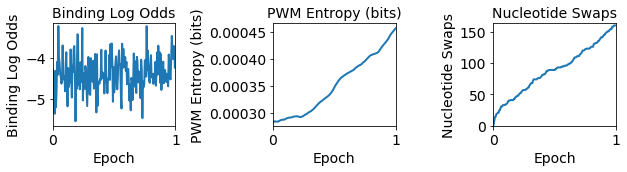

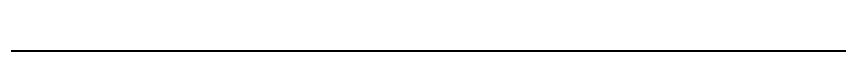

In [6]:
#Optimize max isoform proportions for the 'Alien1' (aka 'Simple') library

seq_template = 'N' * 1000

rand_seed = 1177#14755

#Run SeqProp Optimization

K.clear_session()

set_seed(rand_seed)

print("Running optimization experiment 'DragoNN SPI1 Maximization'")

#Number of PWMs to generate per objective
n_sequences = 1
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1
#Number of steps (grad updates) per epoch
steps_per_epoch = 200
#Either 'pwm' or 'sample'
eval_mode = 'sample'
#Normalize sequence logits
normalize_logits = False
#Number of One-hot validation sequences to sample from the PWM
n_valid_samples = 64

sequence_templates = [
    seq_template
]

losses, val_losses = zip(*[
    get_earthmover_loss(
        pwm_start=0,
        pwm_end=1000,
        pwm_target_bits=1.8,
        pwm_entropy_weight=0.0
    )
])

transforms = [
    None
]

seqprop_predictors, valid_monitors, train_histories, valid_histories = run_seqprop(sequence_templates, losses, val_losses, transforms, n_sequences, n_samples, n_valid_samples, eval_mode, normalize_logits, n_epochs, steps_per_epoch)

seqprop_predictor, valid_monitor, train_history, valid_history = seqprop_predictors[0], valid_monitors[0], train_histories[0], valid_histories[0]


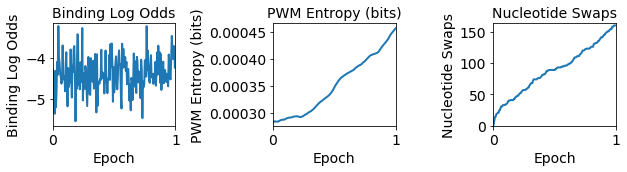

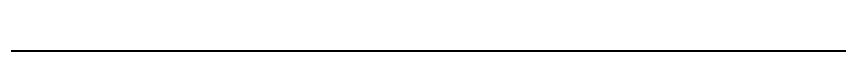

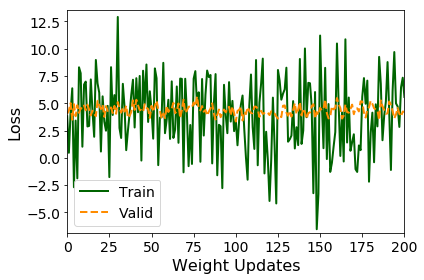

In [7]:
#Store statistics for optimized sequence

fig_name = "eval_steps_seqprop_dragonn_max_spi1_singlesample_200_updates"
save_figs = True

valid_monitor.plot_metrics_and_pwm(fig_name=fig_name if save_figs else None)

f = plt.figure(figsize=(6, 4))

l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(train_history.val_loss_history), color='darkgreen', linewidth=2, linestyle='-', label='Train')
l2 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(valid_history.val_loss_history), color='darkorange', linewidth=2, linestyle='--', label='Valid')

plt.xlabel("Weight Updates", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0, n_epochs * steps_per_epoch)
plt.ylim(min(np.min(train_history.val_loss_history), np.min(valid_history.val_loss_history)) * 1.05, max(np.max(train_history.val_loss_history), np.max(valid_history.val_loss_history)) * 1.05)

plt.legend(handles=[l1[0], l2[0]], fontsize=14)
plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + '_loss.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '_loss.svg')
    plt.savefig(fig_name + '_loss.eps')

plt.show()


Running optimization experiment 'DragoNN SPI1 Maximization'
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 79s 39ms/step - loss: 3.7567


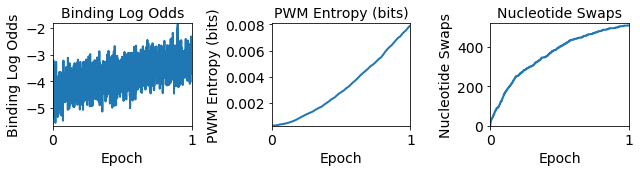

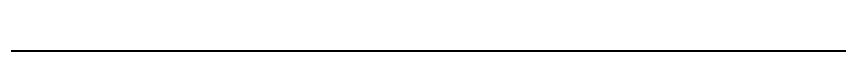

In [8]:
#Optimize max isoform proportions for the 'Alien1' (aka 'Simple') library

seq_template = 'N' * 1000

rand_seed = 1177#14755

#Run SeqProp Optimization

K.clear_session()

set_seed(rand_seed)

print("Running optimization experiment 'DragoNN SPI1 Maximization'")

#Number of PWMs to generate per objective
n_sequences = 1
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000
#Either 'pwm' or 'sample'
eval_mode = 'sample'
#Normalize sequence logits
normalize_logits = False
#Number of One-hot validation sequences to sample from the PWM
n_valid_samples = 64

sequence_templates = [
    seq_template
]

losses, val_losses = zip(*[
    get_earthmover_loss(
        pwm_start=0,
        pwm_end=1000,
        pwm_target_bits=1.8,
        pwm_entropy_weight=0.0
    )
])

transforms = [
    None
]

seqprop_predictors, valid_monitors, train_histories, valid_histories = run_seqprop(sequence_templates, losses, val_losses, transforms, n_sequences, n_samples, n_valid_samples, eval_mode, normalize_logits, n_epochs, steps_per_epoch)

seqprop_predictor, valid_monitor, train_history, valid_history = seqprop_predictors[0], valid_monitors[0], train_histories[0], valid_histories[0]


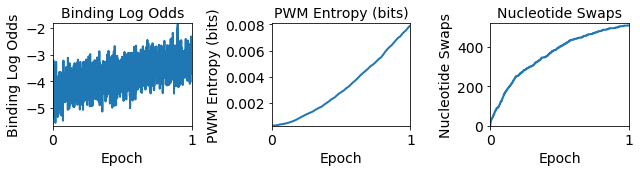

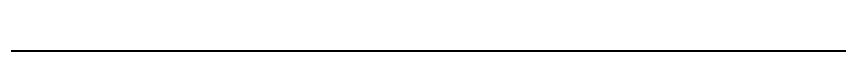

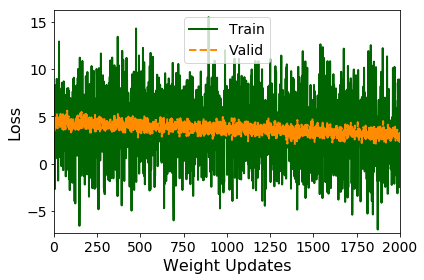

In [9]:
#Store statistics for optimized sequence

fig_name = "eval_steps_seqprop_dragonn_max_spi1_singlesample_2000_updates"
save_figs = True

valid_monitor.plot_metrics_and_pwm(fig_name=fig_name if save_figs else None)

f = plt.figure(figsize=(6, 4))

l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(train_history.val_loss_history), color='darkgreen', linewidth=2, linestyle='-', label='Train')
l2 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(valid_history.val_loss_history), color='darkorange', linewidth=2, linestyle='--', label='Valid')

plt.xlabel("Weight Updates", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0, n_epochs * steps_per_epoch)
plt.ylim(min(np.min(train_history.val_loss_history), np.min(valid_history.val_loss_history)) * 1.05, max(np.max(train_history.val_loss_history), np.max(valid_history.val_loss_history)) * 1.05)

plt.legend(handles=[l1[0], l2[0]], fontsize=14)
plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + '_loss.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '_loss.svg')
    plt.savefig(fig_name + '_loss.eps')

plt.show()


Running optimization experiment 'DragoNN SPI1 Maximization'
Optimizing objective 0...
Epoch 1/1
20000/20000 [==============================] - 761s 38ms/step - loss: -13.1892


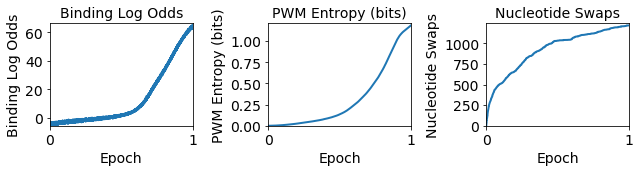

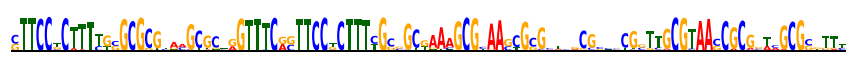

In [10]:
#Optimize max isoform proportions for the 'Alien1' (aka 'Simple') library

seq_template = 'N' * 1000

rand_seed = 1177#14755

#Run SeqProp Optimization

K.clear_session()

set_seed(rand_seed)

print("Running optimization experiment 'DragoNN SPI1 Maximization'")

#Number of PWMs to generate per objective
n_sequences = 1
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1
#Number of steps (grad updates) per epoch
steps_per_epoch = 20000
#Either 'pwm' or 'sample'
eval_mode = 'sample'
#Normalize sequence logits
normalize_logits = False
#Number of One-hot validation sequences to sample from the PWM
n_valid_samples = 64

sequence_templates = [
    seq_template
]

losses, val_losses = zip(*[
    get_earthmover_loss(
        pwm_start=0,
        pwm_end=1000,
        pwm_target_bits=1.8,
        pwm_entropy_weight=0.0
    )
])

transforms = [
    None
]

seqprop_predictors, valid_monitors, train_histories, valid_histories = run_seqprop(sequence_templates, losses, val_losses, transforms, n_sequences, n_samples, n_valid_samples, eval_mode, normalize_logits, n_epochs, steps_per_epoch)

seqprop_predictor, valid_monitor, train_history, valid_history = seqprop_predictors[0], valid_monitors[0], train_histories[0], valid_histories[0]


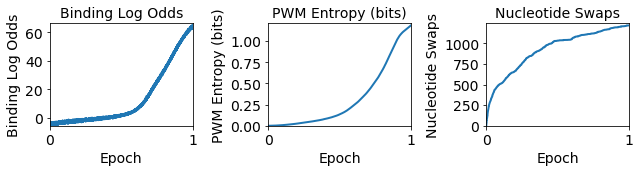

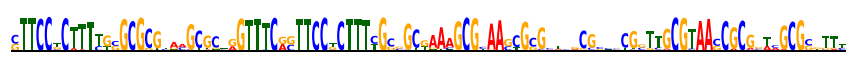

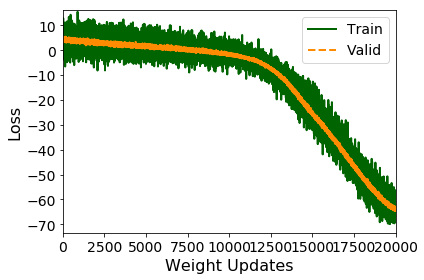

In [11]:
#Store statistics for optimized sequence

fig_name = "eval_steps_seqprop_dragonn_max_spi1_singlesample_20000_updates"
save_figs = True

valid_monitor.plot_metrics_and_pwm(fig_name=fig_name if save_figs else None)

f = plt.figure(figsize=(6, 4))

l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(train_history.val_loss_history), color='darkgreen', linewidth=2, linestyle='-', label='Train')
l2 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(valid_history.val_loss_history), color='darkorange', linewidth=2, linestyle='--', label='Valid')

plt.xlabel("Weight Updates", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0, n_epochs * steps_per_epoch)
plt.ylim(min(np.min(train_history.val_loss_history), np.min(valid_history.val_loss_history)) * 1.05, max(np.max(train_history.val_loss_history), np.max(valid_history.val_loss_history)) * 1.05)

plt.legend(handles=[l1[0], l2[0]], fontsize=14)
plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + '_loss.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '_loss.svg')
    plt.savefig(fig_name + '_loss.eps')

plt.show()
